In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [29]:
import os
import numpy as np
import matplotlib.pylab as plt
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, Video, Audio
import ipywidgets as widgets
import scipy.io as sio
from fxpmath import Fxp
sys.path.append('../src')
from ssl_utils import *

## CAR output

### Define functions

In [30]:
cnt = 480
n_ch = 26
car_out = np.zeros((n_ch, cnt))
def car_out_chan(chans =[]):
    T = range(car_out.shape[1])

    for i in range(len(chans)):
        ch = chans[i]
        plt.plot(T, car_out[ch,:])

    plt.show()
    
def car_out_fft(car_out = np.zeros((cnt,n_ch)), chans=[], sr = 48000):
        '''
        [frequency domain plot] fft plots (gain vs frequency plot) - for impulse response
        '''
        fft_rsp = np.fft.fft(car_out)
        num_transfer_functions, num_samples = fft_rsp.shape
        xaxis = np.tile(np.linspace(0, sr, num_samples), [num_transfer_functions, 1])
        x = (xaxis[:, :xaxis.shape[1]//2]).T
        y = (20 * np.log10(1e-20+np.abs(fft_rsp[:, :fft_rsp.shape[1]//2]))).T

        if len(chans) !=0 :
            # plot frequency response of all channels in the upper plot and the selected channel in the lower plot

            fig, ax = plt.subplots(2, figsize=[6,7], gridspec_kw={'hspace': 0.2})#,

            ax[0].set_xscale('log')
            ax[0].set_xlim([100,10_000])
            ax[0].set_ylim([-20, np.max(y)+10])
            ax[0].plot(x,y,'k', lw=0.5)
            print(x.shape, y.shape)
            ax[0].plot(x[:,::10],y[:,::10],'k', lw=2)
            ax[0].set_xlabel('log of frequency [Hz]')
            ax[0].set_ylabel('Magnitude [dB]')
            ax[0].grid(alpha=0.2, which='both', ls='-')

            for chan in chans:
                x = (xaxis[chan, :xaxis.shape[1]//2]).T
                y = (20 * np.log10(1e-20+np.abs(fft_rsp[chan, :fft_rsp.shape[1]//2]))).T
                ax[1].plot(x,y, lw=2, label=f'chan {chan}')
            ax[1].set_xscale('log')
            ax[1].set_xlim([10,20_000])
            ax[1].set_ylim([-20, np.max(y)+10])
            ax[1].legend()
            ax[1].set_xlabel('log of frequency [Hz]')
            ax[1].set_ylabel('Magnitude [dB]')
            ax[1].grid(alpha=0.2, which='both', ls='-')
        else:
            # plot frequency response of all channels

            fig, ax = plt.subplots(1, figsize=[6,4])

            ax.set_xscale('log')
            ax.set_xlim([100,10_000])
            # ax.set_ylim([-20, 100])
            ax.plot(x,y,'k', lw=0.5)
            print(x.shape, y.shape)
            ax.plot(x[:,::10],y[:,::10],'k', lw=2)
            ax.set_xlabel('log of frequency [Hz]')
            ax.set_ylabel('Magnitude [dB]')
            ax.grid(alpha=0.2, which='both', ls='-')

            
def car_out_plot(time_range=[0,1]):
    '''
    plot the output of CAR simulation results of all the channels
    '''
    fig, ax = plt.subplots(1, figsize=[10,7], gridspec_kw={'hspace': 0.4})#, sharex=True )

    idx_min =  np.int(time_range[0]*len(car_out))
    idx_max =  np.int(time_range[1]*len(car_out))
        
#     car_pcolor = ax.pcolorfast(np.abs(car_out[idx_min:idx_max]))
    car_pcolor = ax.pcolorfast(np.transpose(np.abs(car_out[idx_min:idx_max])))
    plt.colorbar(car_pcolor)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('channels') 
    

def plot_mr(mr):
    fig, ax = plt.subplots(figsize=(6,5))
    plt.pcolor(mr)
    plt.colorbar()
#     plt.title(f'r [{0}]')
    
def plot_mrec(mrec):
    fig, ax = plt.subplots()
    plt.pcolor(mrec)
    plt.colorbar()
    
def plot_conv2d_feature_maps (layer, k, h, w, s3, z3, fileloc):          
    fm = np.empty((k,h,w))
    line = []
    with open(fileloc) as f:
        for i in range(h*w):
            line = f.readline().split()
#             print(line)           
            for j in range(k):
                r = i // w
                c = i % w
                fm[j][r][c]=(int(line[j+1])-z3)*s3
#                 fm[j][r][c]=line[j+1]
#                 print(line[j+1],(int(line[j+1])+46), (int(line[j+1])+46)*0.02145662158727646)
    plt.figure(figsize=(20,20))
    for i in range(k):
        plt.subplot(8,5,i+1)
        plt.imshow(fm[i,:,:])
        plt.title("ch "+ str(i))
    plt.colorbar()
    plt.show()
    return fm

def plot_mqcrec(fileloc='', rec_img_w=0, rec_img_h=0):
    mqcRec = np.zeros((rec_img_w*rec_img_h))
    with open(fileloc) as f:
        for i in range(rec_img_w*rec_img_h):
            line = f.readline().split()
#             print(line[0])
            if line[1] != 'x':
                mqcRec[int(line[0])] = line[1]


    mqcRec_img = np.zeros((rec_img_h, rec_img_w))
    for i in range(len(mqcRec)):
        mqcRec_img[ i // rec_img_w][i % rec_img_w] = mqcRec[i]

    plot_mrec(mqcRec_img)   
    print(mqcRec_img[:][1])
    return mqcRec, mqcRec_img

### Prepare and save AVA datasets in files and mems 

In [31]:
tw_w = widgets.ToggleButtons( options=[1, 2, 4, 5, 8, 10, 15, 25, 50, 75, 90, 100, 120], value=10, description='tw[ms]:', disabled=True )
data_type_w = widgets.ToggleButtons(options=['train', 'test'], value = 'test', description='data_type', disabled=False)
widgets.VBox([tw_w, data_type_w])

In [32]:
sr = 48
tw = tw_w.value
tw = sr * tw
data_type = data_type_w.value
if data_type=='train':
    locs_w = widgets.ToggleButtons( options=['D1_01','D1_02','D1_03', 'D1_04', 'D2_01', 'D2_02', 'D1D2_01','D1D2_02'], value='D1_02', description='Source loc', disabled=False )
elif data_type == 'test':
    locs_w = widgets.ToggleButtons( options=['D1_02', 'D2_02','D1D2_02'], value='D1_02', description='Source loc', disabled=False )
widgets.VBox([locs_w])
# specify sound file location and load sound

(96000.0, 96479.0)

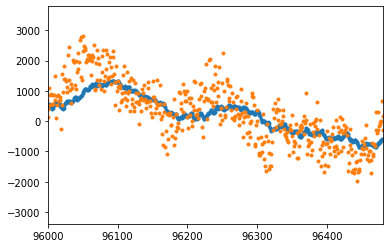

In [33]:
loc = locs_w.value
record_path = f'../datasets/AVA_dataset/train/ADI_PINK_{loc}.mat'
sound_data = sio.loadmat(record_path)

# extract m1 & m2 signal
index = 200
start = index*tw
end = (index+1)*tw-1

sound_m1 = sound_data['m1'] #.reshape(-1)
sound_m2 = sound_data['m2']#.reshape(-1)
x = np.array(range(len(sound_m1)))
plt.plot(x, sound_m1, '.', x, sound_m2, '.')
plt.xlim(start,end)
# print(sound_m1[:-1][0:10])
# print(sound_m1[0:10])

In [34]:
index = 1000
start = index*tw
end = (index+1)*tw-1
sound_mic1 = np.round(sound_m1[start:end])
sound_mic2 = np.round(sound_m2[start:end])
print(start, end)
np.savetxt(f'../../hdl_design/datasets/AVA_dataset/{data_type}/{index}_ADI_PINK_{loc}_sound_m1.txt', sound_mic1.ravel(), fmt="%d")
np.savetxt(f'../../hdl_design/datasets/AVA_dataset/{data_type}/{index}_ADI_PINK_{loc}_sound_m2.txt', sound_mic2.ravel(), fmt="%d")

save_1d_arr_in_mem(b = sound_mic1.ravel(), signed = True, nbits=16, n_frac =0, fileloc=f'../../hdl_design/datasets/AVA_dataset/{data_type}/mem/{index}_ADI_PINK_{loc}_sound_m1.txt')
save_1d_arr_in_mem(b =  sound_mic2.ravel(), signed = True, nbits=16, n_frac =0, fileloc=f'../../hdl_design/datasets/AVA_dataset/{data_type}/mem/{index}_ADI_PINK_{loc}_sound_m2.txt') 


480000 480479


In [47]:
start = 0
end = start + 5000
sound_mic1 = np.round(sound_m1[start:end])
sound_mic2 = np.round(sound_m2[start:end])
print(start, end)
# np.savetxt(f'../../hdl_design/datasets/AVA_dataset/{data_type}/{index}_ADI_PINK_{loc}_sound_m1.txt', sound_mic1.ravel(), fmt="%d")
# np.savetxt(f'../../hdl_design/datasets/AVA_dataset/{data_type}/{index}_ADI_PINK_{loc}_sound_m2.txt', sound_mic2.ravel(), fmt="%d")

save_1d_arr_in_mem(b = sound_mic1.ravel(), signed = True, nbits=16, n_frac =0, fileloc=f'../../hdl_design/datasets/AVA_dataset/{data_type}/mem/ADI_PINK_{loc}_sound_m1.txt')
save_1d_arr_in_mem(b = sound_mic2.ravel(), signed = True, nbits=16, n_frac =0, fileloc=f'../../hdl_design/datasets/AVA_dataset/{data_type}/mem/ADI_PINK_{loc}_sound_m2.txt') 


0 5000


In [8]:
a = sound_m1[start:end]
print(a.shape)
b = a.ravel()
print(b)

(479, 1)
[-6.51362439e+02 -6.76190090e+02 -6.77528018e+02 -6.67545953e+02
 -6.43197332e+02 -6.07539909e+02 -6.00576926e+02 -6.05041330e+02
 -6.00472423e+02 -5.92137935e+02 -6.01951234e+02 -5.69539402e+02
 -4.90428861e+02 -4.18825705e+02 -3.74426443e+02 -3.41348748e+02
 -2.61968261e+02 -1.40897687e+02 -4.80798225e+01 -2.34710167e+01
 -6.51663132e+01 -9.11582116e+01 -7.68301326e+01 -7.54140904e+01
 -7.06117610e+01 -5.46123132e+01 -4.77078953e+01 -1.55403215e+01
  2.71915390e+01  4.28926363e+01  2.16410557e+01  1.02003209e+01
  3.91401871e+01  8.98897288e+01  1.24852093e+02  1.27041051e+02
  9.39125475e+01  5.48877586e+01  3.11983041e+01  3.73583516e+01
  4.21413988e+01  2.46718728e+01  1.56159114e+01  1.80605795e+01
  7.72089425e+00  1.26406985e+01  3.21099718e+01  3.74965911e+01
  2.51922770e+01  1.23954198e+01  4.57841884e+01  8.48126381e+01
  1.32290143e+02  1.94129303e+02  2.18459577e+02  2.27827701e+02
  2.55244841e+02  2.64685889e+02  2.60720887e+02  2.39611800e+02
  2.31495474e+02

### Analyse 'CAR_tb.sv' and/or 'SoundSourceLocalizer_tb.sv' results

In [9]:
line = []
cnt = 48*10
num_frac_bits = 10
n_ch = 16
t_start, t_end = 0, 48*10
car_out = np.zeros(( cnt, n_ch))
car1 = np.zeros(( cnt, n_ch))
car2 = np.zeros(( cnt, n_ch))
filename = f'CAR_V1_SimOut_ADI_PINK_{loc}'
filename = f'SSL_CarSimOut_0_ADI_PINK_D1_02'

fileloc = f'../../hdl_design/result/{data_type}_data/{filename}_sound_m1.txt'
with open(fileloc) as f:
    for i in range(cnt):
        line = f.readline().split()
        for j in range(n_ch):
            if line[j] != 'x':
                car_out[i][j] = line[j]
car_out = np.multiply(car_out, 1/(2**num_frac_bits))
car_out_plot(time_range=[0, 1])
car1 = car_out
car_out = np.zeros(( cnt, n_ch))
fileloc = f'../../hdl_design/result/{data_type}_data/{filename}_sound_m2.txt'
with open(fileloc) as f:
    for i in range(cnt):
        line = f.readline().split()
        for j in range(n_ch):
            if line[j] != 'x':
                car_out[i][j] = line[j]
car_out = np.multiply(car_out, 1/(2**num_frac_bits))
car_out_plot(time_range=[0, 1])
car2 = car_out


IndexError: list index out of range

In [10]:
# printed results should be almos equal to simulation
print(sound_m2[0])
print(sound_m1[0])
print(car2[470][0])
print(car1[470][0])

[-41.24281533]
[-6.57860858]
0.0
0.0


### Analyse 'CochleaProcessing_tb.sv' and/or 'SoundSourceLocalizer_tb.sv' results

#### Plot acc_qcRec

In [21]:

index = 0
acc_qcr = np.zeros((rec_img_h, rec_img_w))
acc_qcr_addr = np.zeros((rec_img_h, rec_img_w))

filename = f'CochleaProcessing_acc_qcRec_{index}_ADI_PINK_{loc}'
filename = f'SSL_acc_qcRec_{index}_ADI_PINK_{loc}' 

fileloc = f'../../hdl_design/result/{data_type}_data/{filename}.txt'
with open(fileloc) as f:
    for i in range(rec_img_h):
        line = f.readline().split()
        for j in range(rec_img_w):
            if line[j] != 'x':
                acc_qcr[i][j] = line[j]
                
plot_mrec(acc_qcr)

NameError: name 'rec_img_h' is not defined

#### Plot mqcRec

##### Behv simulation

In [22]:
rec_img_h = 9
rec_img_w = 12

index=2

filename = f'CochleaProcessing_mqcRec_{index}_ADI_PINK_{loc}'

filename = f'SSL_mqcRec_{index}_ADI_PINK_{loc}'

fileloc = f'../../hdl_design/result/{data_type}_data/{filename}.txt'

mqcrec_img = plot_mqcrec(fileloc, rec_img_w, rec_img_h)



FileNotFoundError: [Errno 2] No such file or directory: '../../hdl_design/result/test_data/SSL_mqcRec_2_ADI_PINK_D1_02.txt'

In [23]:
index=0

filename = f'SSL_mqcRec_{index}_ADI_PINK_{loc}.txt'

fileloc = f'../../hdl_design/result/{data_type}_data/{filename}'

mqcRec = np.zeros((rec_img_w*rec_img_h))
with open(fileloc) as f:
    for i in range(rec_img_w*rec_img_h):
        line = f.readline().split()
        if line[1] != 'x':
            mqcRec[int(line[0])] = line[1]


mqcRec_img = np.zeros((rec_img_h, rec_img_w))
for i in range(len(mqcRec)):
    mqcRec_img[ i // rec_img_w][i % rec_img_w] = mqcRec[i]

plot_mrec(mqcRec_img)   
print(mqcRec_img[:][1])
return mqcRec_img

IndexError: list index out of range

##### Post Imp Simulation

[ 0.  0.  9.  9.  1.  4. 20. 31. 20.  6. -7. 13.]


array([[ -4.,   8.,  14.,   6.,  -6.,   0.,   8.,  12.,  -8., -13., -14.,
        -11.],
       [  0.,   0.,   9.,   9.,   1.,   4.,  20.,  31.,  20.,   6.,  -7.,
         13.],
       [  9., -16., -35., -34.,  -7.,  13., -15.,  -8.,  18.,  31.,  41.,
         52.],
       [ 13.,  19.,   3., -11., -30., -33., -66., -61., -49., -49., -56.,
        -57.],
       [ 38.,  37.,  48.,  38.,   0.,  -4.,   7., -25., -25., -28., -23.,
        -10.],
       [ 14., -13., -26.,  -1.,  29.,  22.,  26.,  59.,  83.,  87.,  93.,
         99.],
       [ 28.,   2.,  -9.,  14.,   6.,  -4.,  -5.,   8.,  27.,  17.,   3.,
        -13.],
       [ 23.,  22.,  30.,   4.,   3.,   7.,  12.,   4., -21., -46., -30.,
        -22.],
       [ 22.,  10.,   4.,  -7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]])

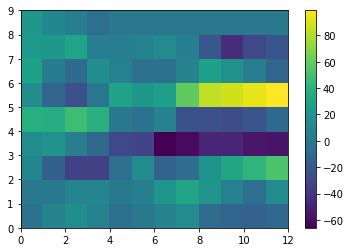

In [24]:
index=2

filename = f'CochleaProcessing_mqcRec_{index}_ADI_PINK_{loc}_imp.txt'

fileloc = f'../../hdl_design/result/{data_type}_data/{filename}'

mqcrec, mqcrec_img = plot_mqcrec(fileloc, rec_img_w, rec_img_h)
mqcrec_img

In [26]:

fileloc_mem = f'../../hdl_design/result/{data_type}_data/mem/{filename}'

save_1d_arr_in_mem(b = mqcrec.ravel(), signed = True, nbits=8, n_frac =0, fileloc=fileloc_mem)


#### Dequantize mqcRec based on tfLite parameters

In [11]:
# s1 and z1 are extracted from netron(input layer)
# result should be consistant with the golden model R_12.mrec[0][0][0]
s1 = 0.007598039228469133
z1 = -1

q_mqcrec = np.multiply(mqcRec_img-z1, s1)
plot_mrec(q_mqcrec)
print(q_mqcrec[0][0])

NameError: name 'mqcRec_img' is not defined

## CNN feature maps from CNN_tb.sv

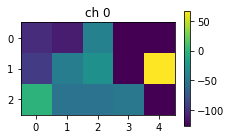

In [30]:
layer = 1
fileloc = f'../../hdl_design/result/test_data/CNN_v2_conv2d_L1_fm_imp.txt'  
k, h, w = 1, 3, 5
s3, z3 = 0.013281820341944695, -128
s3, z3 = 1, 0
fm = []
fm = plot_conv2d_feature_maps(layer, k, h, w, s3, z3, fileloc)

In [31]:
fm

array([[[-103., -113.,  -42., -128., -128.],
        [ -93.,  -45.,  -30., -128.,   67.],
        [  -2.,  -54.,  -54.,  -50., -128.]]])

In [25]:
for i in range(k):
    print(np.where(fm[i] == np.amax(fm[i])))

(array([1]), array([4]))


In [ ]:
array([[-102.      , -116.      ,  -40.999992,  -28.      , -128.      ],
       [ -92.      ,  -67.      ,  -45.999992, -128.      ,   68.      ],
       [  -2.      ,  -30.      ,  -53.      ,  -50.      ,  -98.      ]],

### HDL CNN Loss

In [ ]:
# 'CF_LU'
((16-25)**2 + (25-22)**2 + (25-20)**2 + (25-27)**2 + 3*2**2 + 3**2 + 1)/9